In [1]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import yellowbrick as yb

from fastai.tabular.data import TabularDataLoaders, TabularPandas
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve



seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# declare file paths for the data we will be working on
data_path_1: str = '../data/downsampled/baseline/'
data_path_2: str = '../data/downsampled/timebased/'
modelPath  : str = './models'


# list the names of the datasets we will be using
attacks : list = [ 'DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag' ]
datasets: list = [
    "DNS_vs_all_200000.csv" , "LDAP_vs_all_200000.csv"    , "MSSQL_vs_all_200000.csv" , "NetBIOS_vs_all_200000.csv" ,
    "NTP_vs_all_200000.csv" , "Portmap_vs_all_200000.csv" , "SNMP_vs_all_200000.csv"  , "SSDP_vs_all_200000.csv"    ,
    "Syn_vs_all_200000.csv" , "TFTP_vs_all_200000.csv"    , "UDP_vs_all_200000.csv"   , "UDPLag_vs_all_200000.csv"  ,
]


# set up enumeration of experiment types
Baseline : int = 0
Timebased: int = 1


# print library and python versions for reproducibility
print(
    # \tfaiss:\t\t{faiss.__version__}
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsklearn:\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    python:	3.7.10

    	fastai:		2.4.1
    	matplotlib:	3.3.4
    	numpy:		1.20.3
    	pandas:		1.2.5
    	sklearn:	0.24.2
    	yellowbrick:	1.3.post1
    


In [2]:
def get_file_path(directory: str):
    '''
        Closure that will return a function that returns the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func


# use the get_file_path closure to create a function that will return the path to a file
baseline_path  = get_file_path(data_path_1)
timebased_path = get_file_path(data_path_2)


# create a list of the paths to all of the dataset files
baseline_files : list = list(map(baseline_path , datasets))
timebased_files: list = list(map(timebased_path, datasets))

In [3]:
def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[20::]
        pickleDump: str = f'../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}')
    
    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
        
    # if not, load data and cache it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)

    
    return df


def run_experiment(df: pd.DataFrame, name: str) -> tuple:
    '''
        Run Classification experiment on the given dataset using a Support Vector Machine
        returns the 7-tuple with the following indicies:
        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = 'Label'
    if 'Protocol' in df.columns:
        categorical_features: list = ['Protocol']
    else:
        categorical_features: list = []
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    mds = tabular_learner(dls)
    classes : list = list(mds.dls.vocab)


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a Support Vector Machine
    # using SciKitLearn and print the results 
    model = SVC(random_state=seed)
    # model = SVC(C=1, gamma=0.1, kernel='rbf', random_state=seed)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(f'\tAccuracy: {accuracy_score(y_test, prediction)}\n')
    report = classification_report(y_test, prediction)
    print(report)

   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')


    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)

    return results


def visualize_learning_curve_train(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a learning curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # Track the learning curve of the classifier, here we want the 
    # training and validation scores to approach 1
    visualizer = LearningCurve(results[1], scoring='f1_weighted')
    visualizer.fit(results[3], results[4])
    visualizer.show()


def visualize_learning_curve_test(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a learning curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # Track the learning curve of the classifier, here we want the 
    # training and validation scores to approach 1
    visualizer = LearningCurve(results[1], scoring='f1_weighted')
    visualizer.fit(results[5], results[6])
    visualizer.show()


def visualize_confusion_matrix(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a confusion matrix

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ConfusionMatrix(results[1], classes=results[2], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.show()


def visualize_roc(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ROCAUC(results[1], classes=results[2], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_pr_curve(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(results[1], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_report(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ClassificationReport(results[1], classes=results[2], title=results[0], support=True)
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_class_balance(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.target.ClassBalance(labels=results[0])
    visualizer.fit(results[4], results[6])
    visualizer.show()

In [4]:
baseline_dfs : map = map( load_data    , baseline_files  )
timebased_dfs: map = map( load_data    , timebased_files )
experiments  : zip = zip( baseline_dfs , timebased_dfs   , attacks )

In [5]:
def experiment_runner():
    '''
        A generator that handles running the experiments
    '''
    num = 1
    for baseline, timebased, info in experiments:
        print(f'Running experiment #{num}:\t{info}')

        print('Baseline results\n')
        baseline_results = run_experiment(baseline, f'{info}_vs_all_baseline')
        
        print('Time-based results\n')
        timebased_results = run_experiment(timebased, f'{info}_vs_all_timebased')
        
        num += 1
        yield (baseline_results, timebased_results, info, num)


def do_experiment(num: int) -> tuple:
    '''
        A function that runs the specific experiment specified
    '''
    index = num - 1
    baseline = load_data(baseline_files[index])
    timebased = load_data(timebased_files[index])
    info = attacks[index]

    print(f'Running experiment #{num}:\t{info}')

    print('Baseline results\n')
    baseline_results = run_experiment(baseline, f'{info}_vs_all_baseline')
    
    print('Time-based results\n')
    timebased_results = run_experiment(timebased, f'{info}_vs_all_timebased')

    return (baseline_results, timebased_results, info, num)


experiment = experiment_runner()

## Experiment #1: DNS vs All

In [6]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/DNS_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/DNS_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/DNS_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/DNS_vs_all_200000.csv.pickle
Running experiment #1:	DNS

Baseline results

	Accuracy: 0.8755718892972324

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     20081
           1       0.92      0.82      0.87     19918

    accuracy                           0.88     39999
   macro avg       0.88      0.88      0.88     39999
weighted avg       0.88      0.88      0.88     39999


Time-based results

	Accuracy: 0.8080702017550438

              precision    recall  f1-score   support

           0       0.82      0.79      0.80     20081
           1       0.79      0.83      0.81     19918

    accuracy                           0.81     39999
   macro avg       0.81      0.81      0.81   

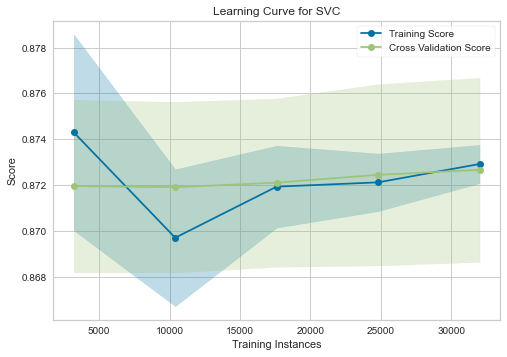

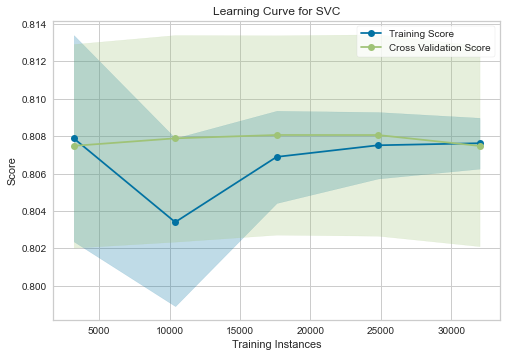

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


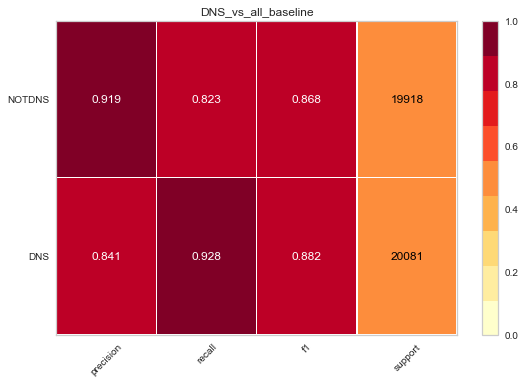

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


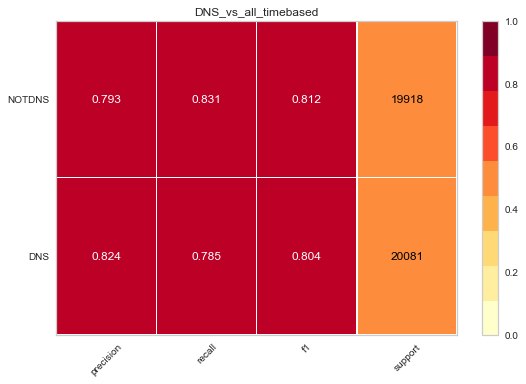

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


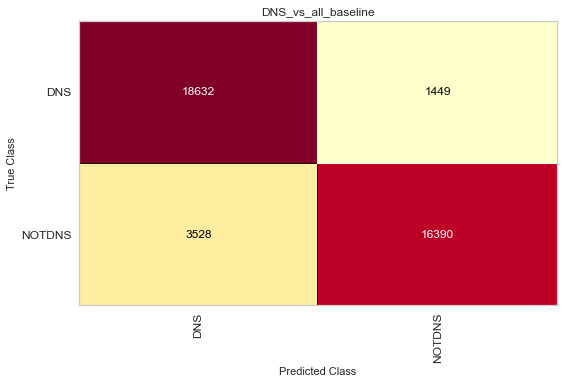

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


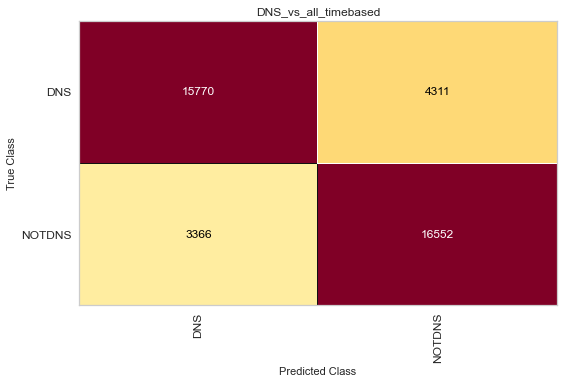

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


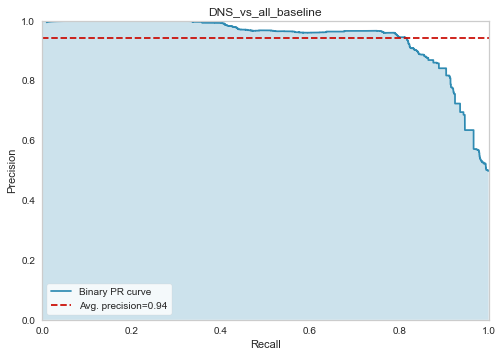

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


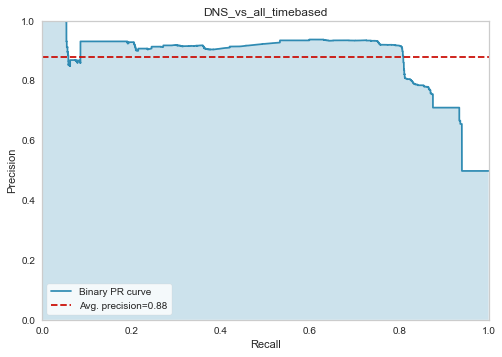

In [7]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #2: LDAP vs All

In [8]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/LDAP_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/LDAP_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/LDAP_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/LDAP_vs_all_200000.csv.pickle
Running experiment #2:	LDAP

Baseline results

	Accuracy: 0.9141228530713268

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     20081
           1       1.00      0.83      0.91     19918

    accuracy                           0.91     39999
   macro avg       0.93      0.91      0.91     39999
weighted avg       0.93      0.91      0.91     39999


Time-based results

	Accuracy: 0.8927723193079827

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     20081
           1       0.94      0.84      0.89     19918

    accuracy                           0.89     39999
   macro avg       0.90      0.89      0.

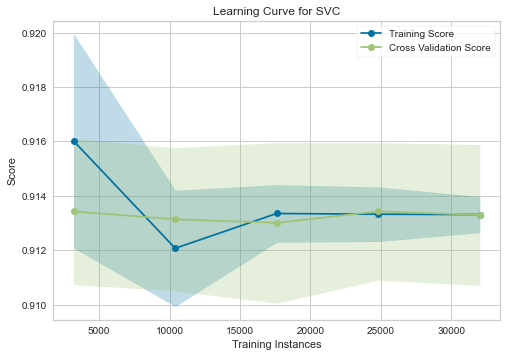

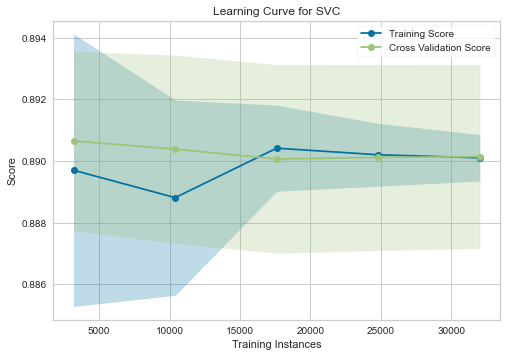

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


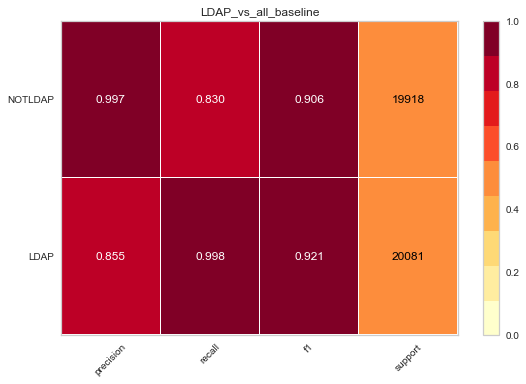

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


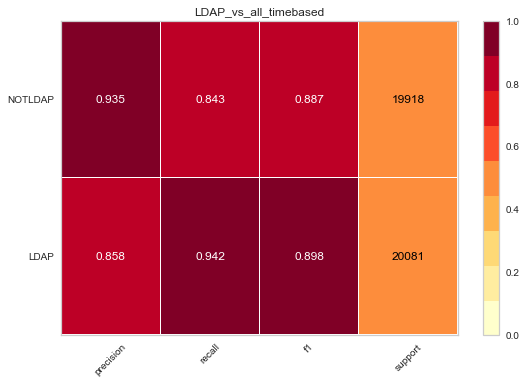

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


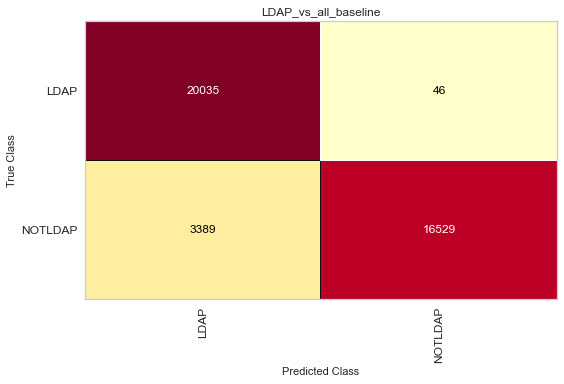

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


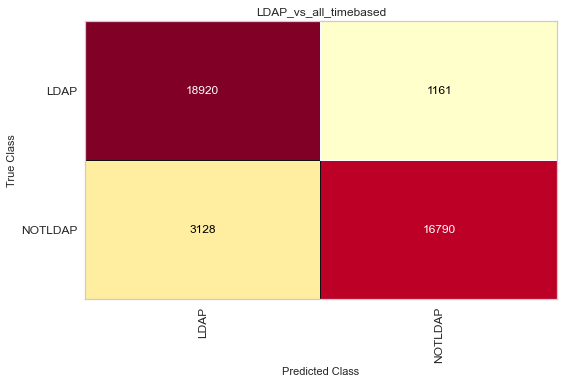

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


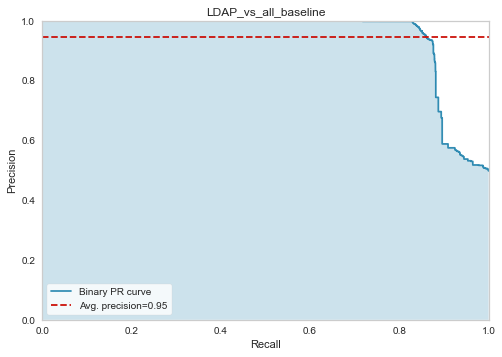

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


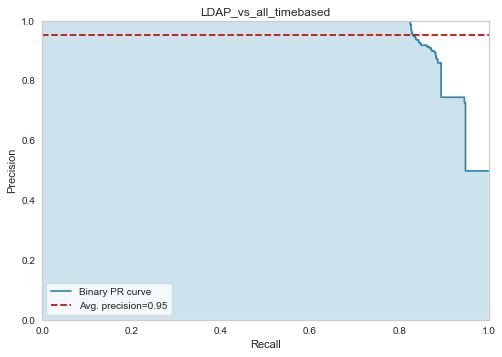

In [9]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #3: MSSQL vs All

In [10]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/MSSQL_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/MSSQL_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/MSSQL_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/MSSQL_vs_all_200000.csv.pickle
Running experiment #3:	MSSQL

Baseline results

	Accuracy: 0.9144978624465612

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     20081
           1       0.97      0.86      0.91     19918

    accuracy                           0.91     39999
   macro avg       0.92      0.91      0.91     39999
weighted avg       0.92      0.91      0.91     39999


Time-based results

	Accuracy: 0.8616215405385135

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     20081
           1       0.86      0.86      0.86     19918

    accuracy                           0.86     39999
   macro avg       0.86      0.86   

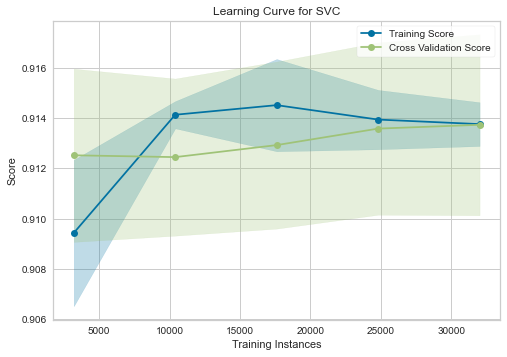

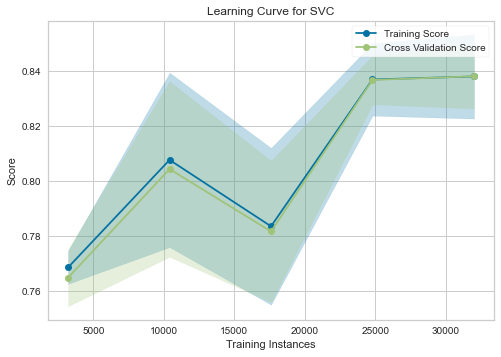

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


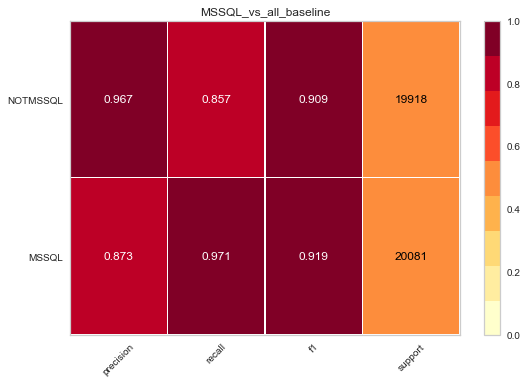

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


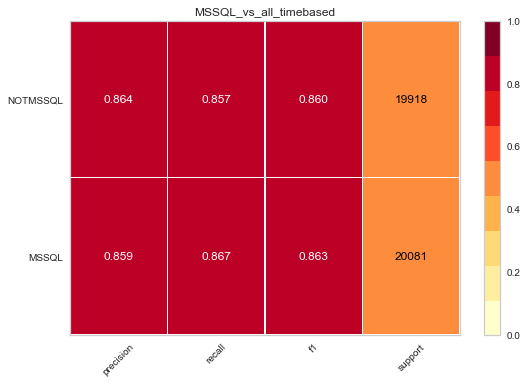

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


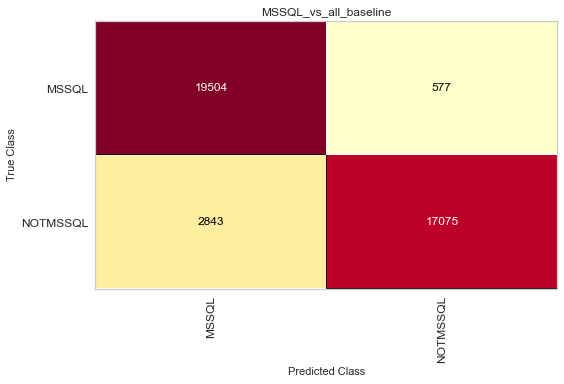

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


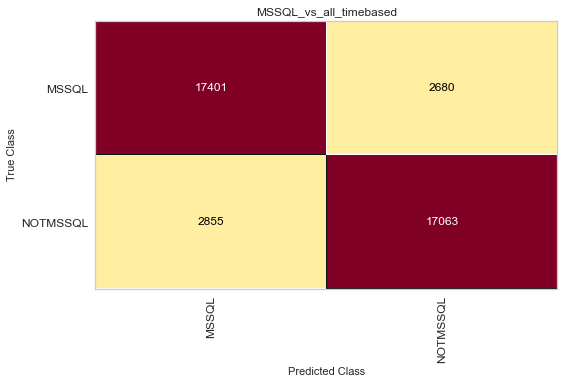

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


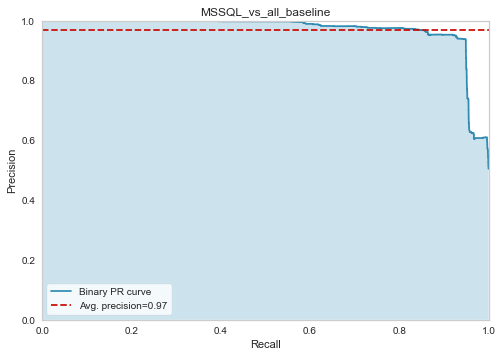

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


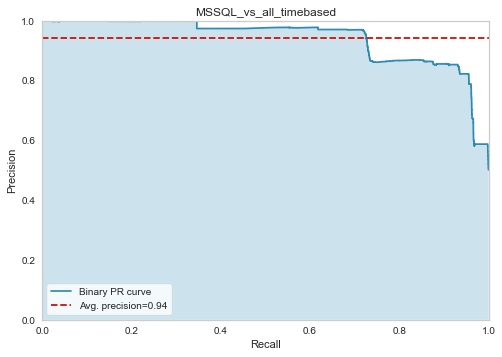

In [11]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #4: NetBIOS vs All

In [12]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/NetBIOS_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/NetBIOS_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/NetBIOS_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/NetBIOS_vs_all_200000.csv.pickle
Running experiment #4:	NetBIOS

Baseline results

	Accuracy: 0.9525238130953274

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     19918
           1       0.92      0.99      0.95     20081

    accuracy                           0.95     39999
   macro avg       0.96      0.95      0.95     39999
weighted avg       0.96      0.95      0.95     39999


Time-based results

	Accuracy: 0.858846471161779

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     19918
           1       0.89      0.82      0.85     20081

    accuracy                           0.86     39999
   macro avg       0.86    

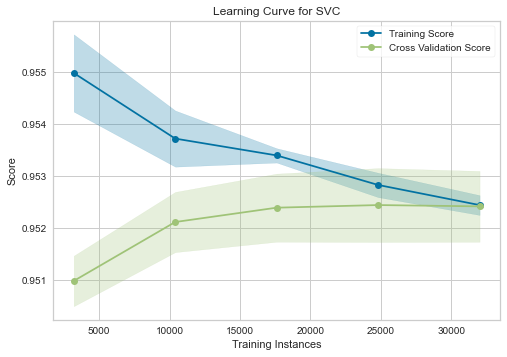

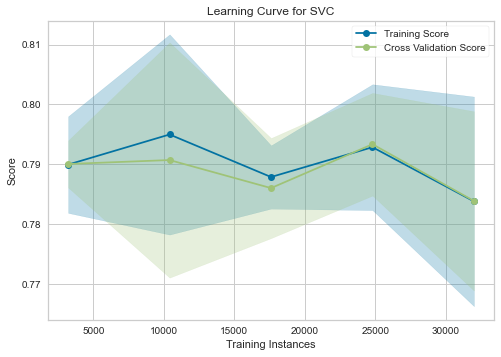

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


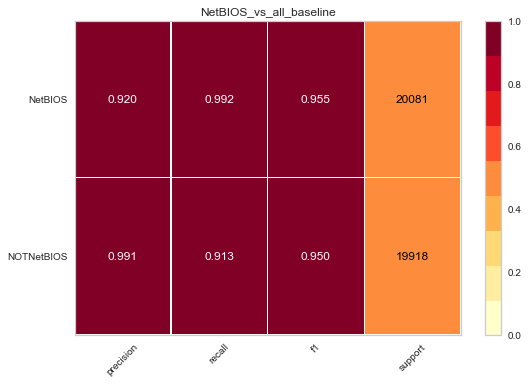

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


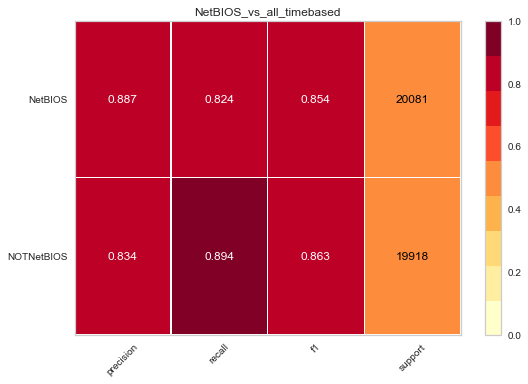

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


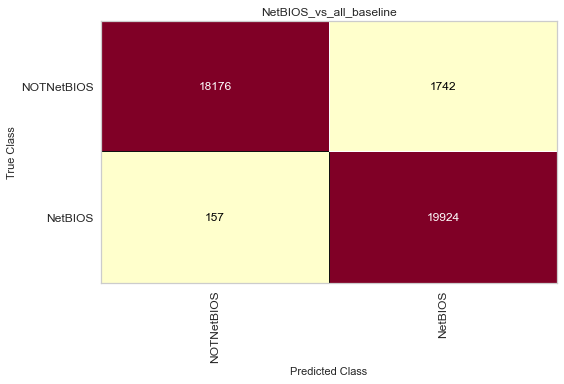

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


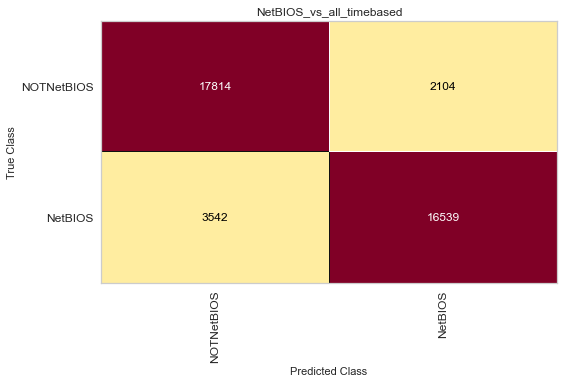

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


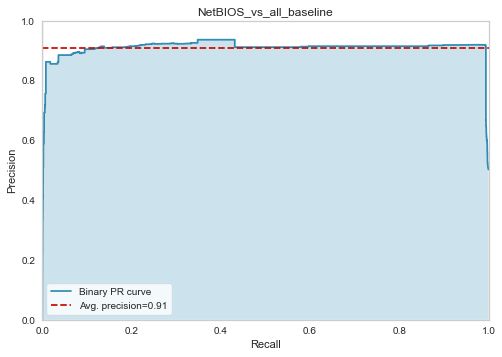

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


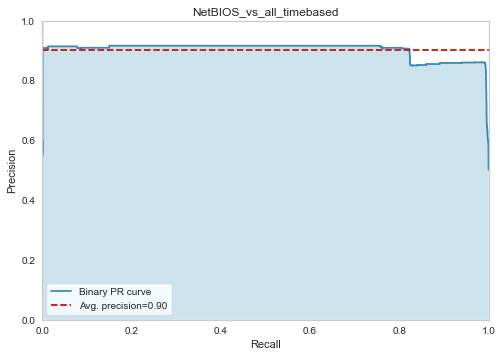

In [13]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #5: NTP vs All

In [14]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/NTP_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/NTP_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/NTP_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/NTP_vs_all_200000.csv.pickle
Running experiment #5:	NTP

Baseline results

	Accuracy: 0.9729493237330933

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     19918
           1       1.00      0.95      0.97     20081

    accuracy                           0.97     39999
   macro avg       0.97      0.97      0.97     39999
weighted avg       0.97      0.97      0.97     39999


Time-based results

	Accuracy: 0.9098477461936548

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     19918
           1       0.89      0.94      0.91     20081

    accuracy                           0.91     39999
   macro avg       0.91      0.91      0.91   

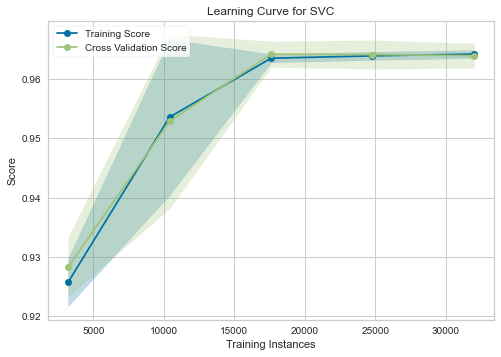

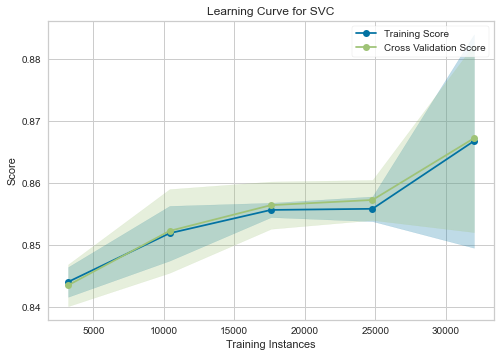

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


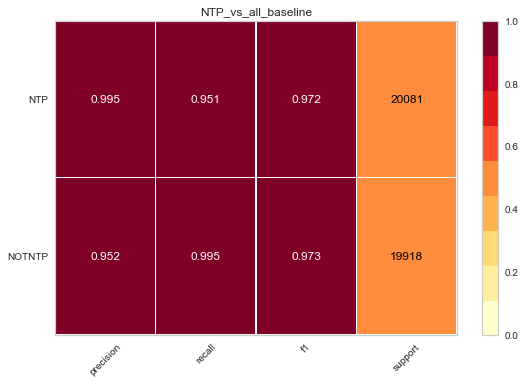

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


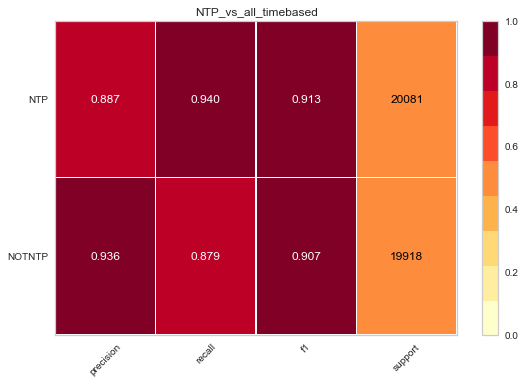

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


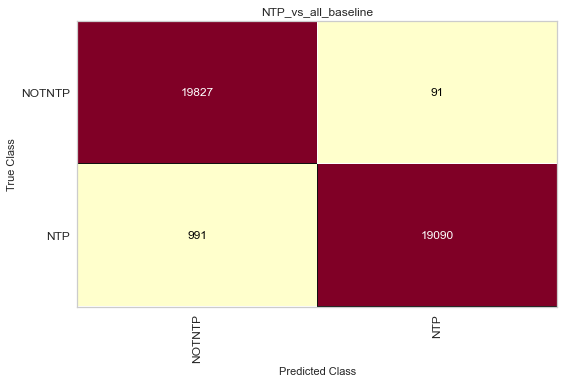

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


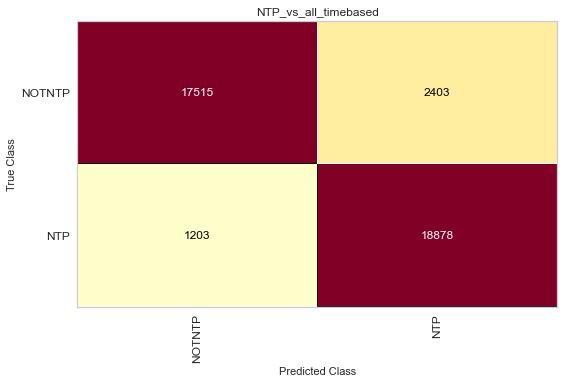

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


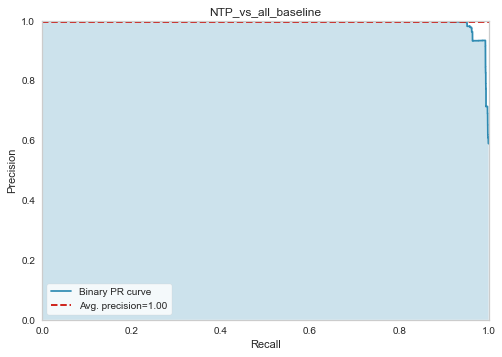

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


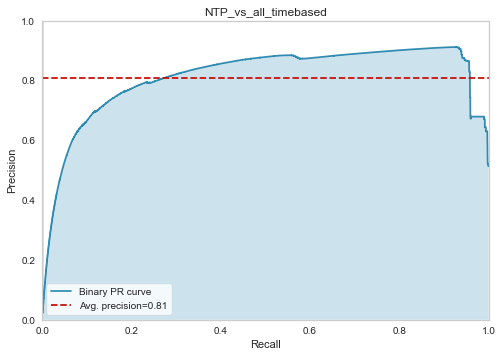

In [15]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #6: Portmap vs All

In [16]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/Portmap_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/Portmap_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/Portmap_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/Portmap_vs_all_200000.csv.pickle
Running experiment #6:	Portmap

Baseline results

	Accuracy: 0.9524238105952649

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     19918
           1       0.92      1.00      0.95     20081

    accuracy                           0.95     39999
   macro avg       0.96      0.95      0.95     39999
weighted avg       0.96      0.95      0.95     39999


Time-based results

	Accuracy: 0.8805470136753419

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     19918
           1       0.89      0.87      0.88     20081

    accuracy                           0.88     39999
   macro avg       0.88   

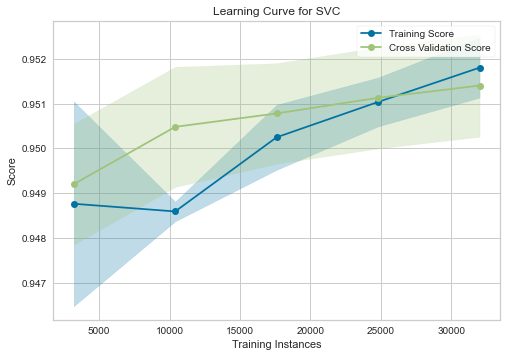

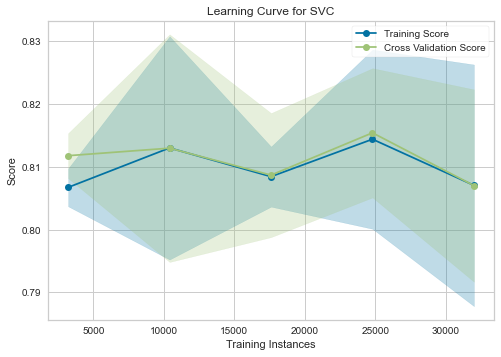

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


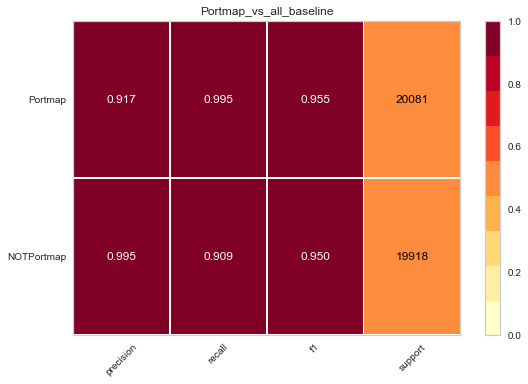

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


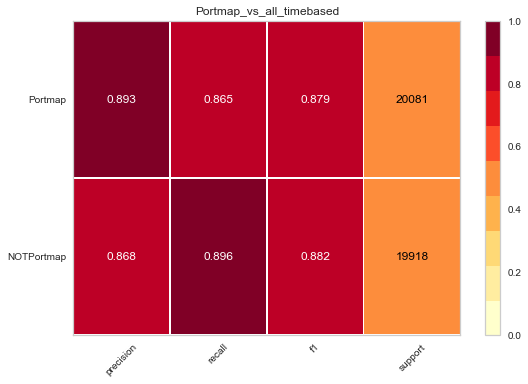

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


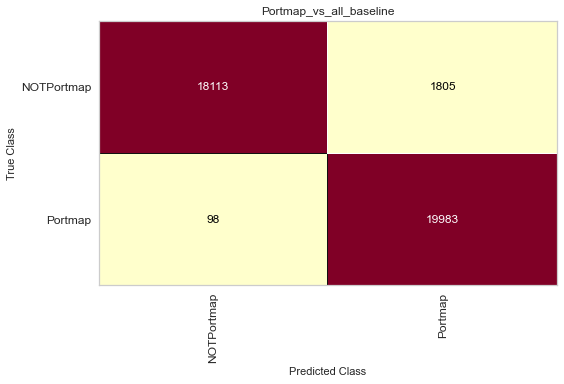

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


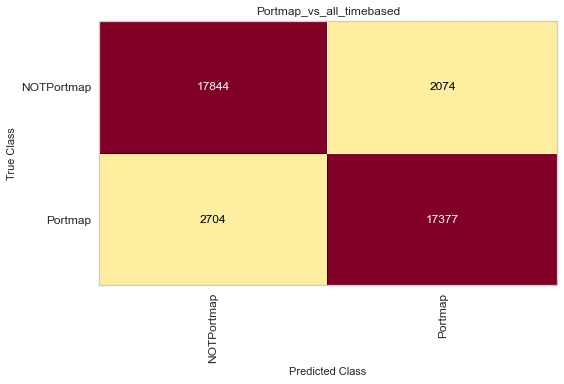

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


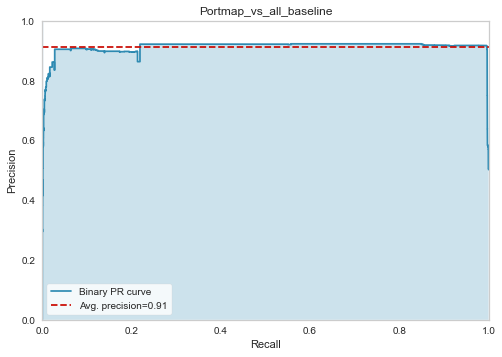

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


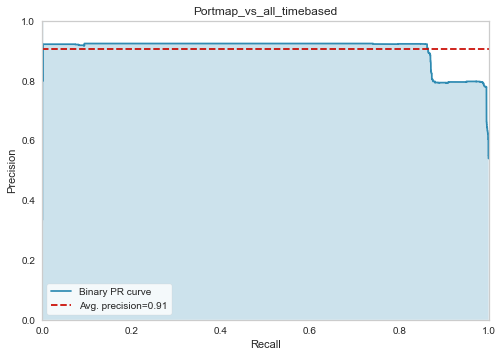

In [17]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #7: SNMP vs All

In [18]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/SNMP_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/SNMP_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/SNMP_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/SNMP_vs_all_200000.csv.pickle
Running experiment #7:	SNMP

Baseline results

	Accuracy: 0.8915972899322483

              precision    recall  f1-score   support

           0       0.95      0.83      0.88     19918
           1       0.85      0.95      0.90     20081

    accuracy                           0.89     39999
   macro avg       0.90      0.89      0.89     39999
weighted avg       0.90      0.89      0.89     39999


Time-based results

	Accuracy: 0.8900722518062951

              precision    recall  f1-score   support

           0       0.93      0.85      0.88     19918
           1       0.86      0.93      0.90     20081

    accuracy                           0.89     39999
   macro avg       0.89      0.89      0.

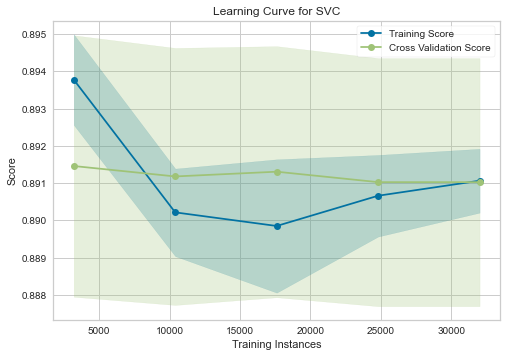

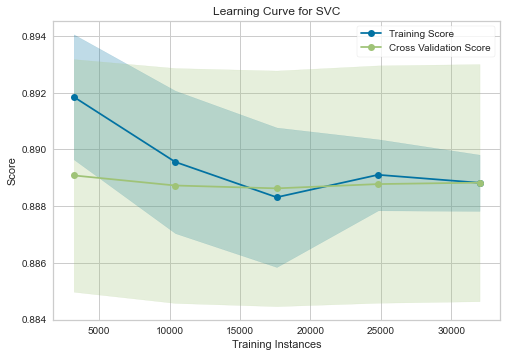

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


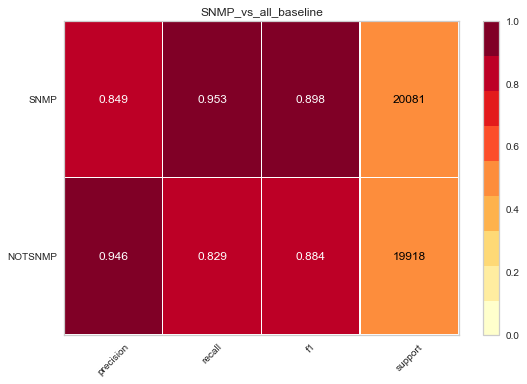

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


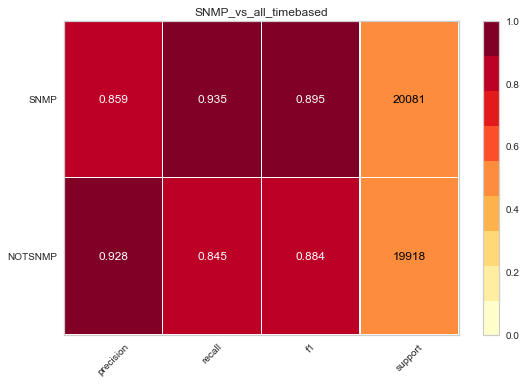

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


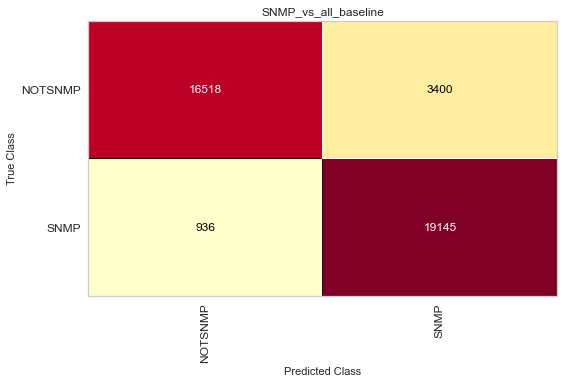

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


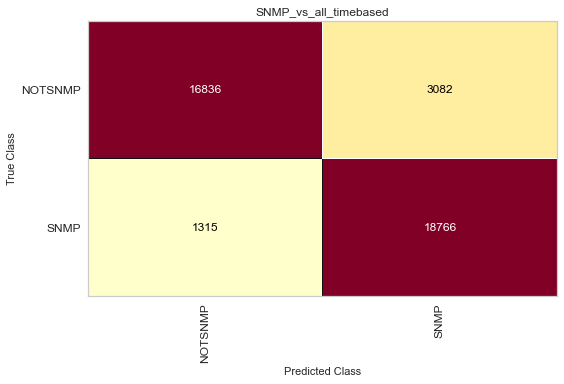

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


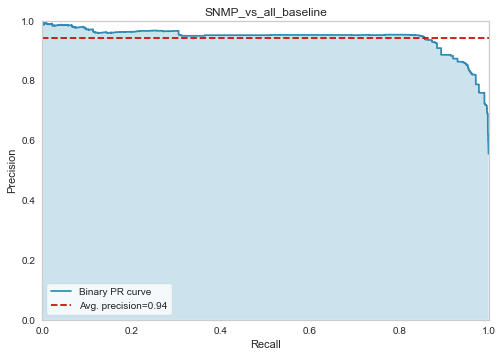

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


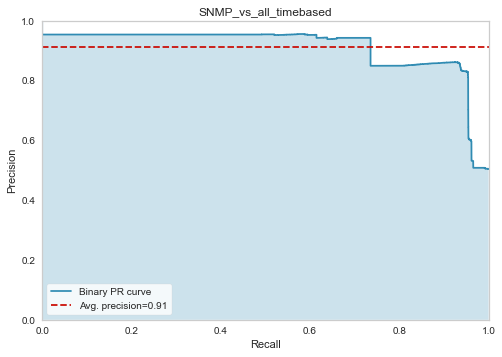

In [19]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #8: SSDP vs All

In [20]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/SSDP_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/SSDP_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/SSDP_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/SSDP_vs_all_200000.csv.pickle
Running experiment #8:	SSDP

Baseline results

	Accuracy: 0.890947273681842

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     19918
           1       0.83      0.98      0.90     20081

    accuracy                           0.89     39999
   macro avg       0.90      0.89      0.89     39999
weighted avg       0.90      0.89      0.89     39999


Time-based results

	Accuracy: 0.8446711167779194

              precision    recall  f1-score   support

           0       0.90      0.77      0.83     19918
           1       0.80      0.92      0.86     20081

    accuracy                           0.84     39999
   macro avg       0.85      0.84      0.8

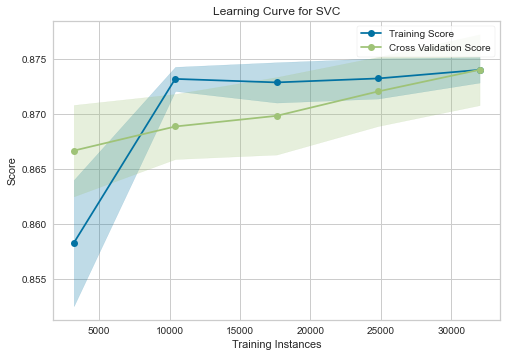

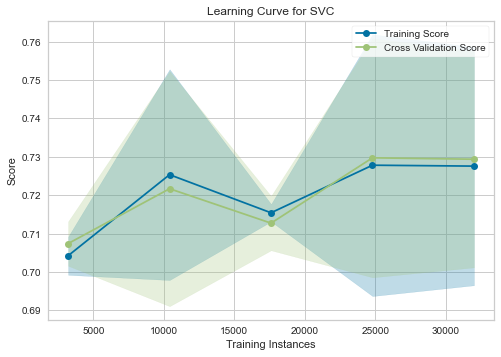

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


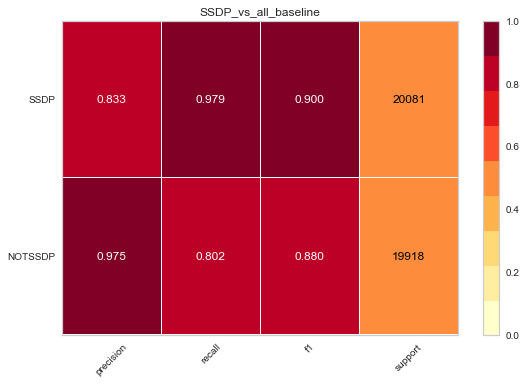

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


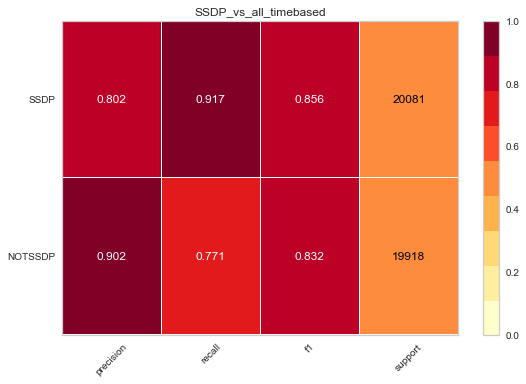

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


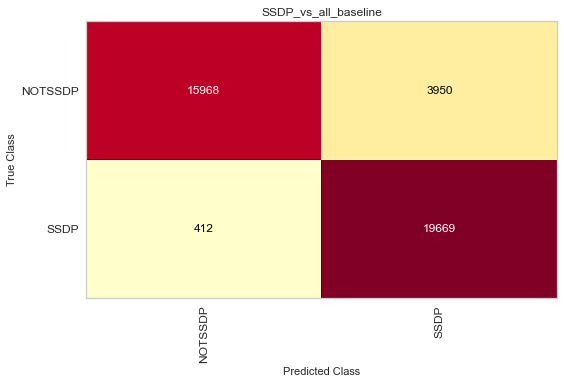

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


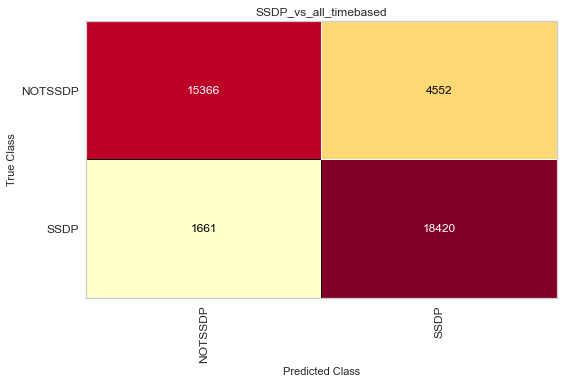

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


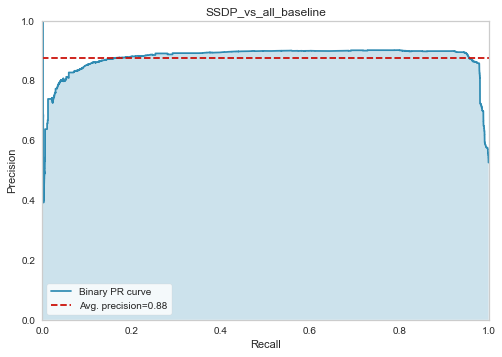

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


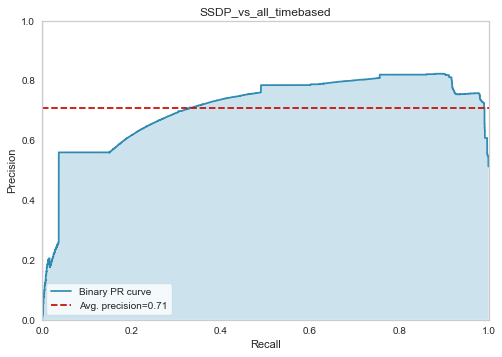

In [21]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #9: Syn vs All

In [22]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/Syn_vs_all_200000.csv
	To Dataset Cache: ../data/cache/baseline/Syn_vs_all_200000.csv.pickle
Loading Dataset: ../data/downsampled/timebased/Syn_vs_all_200000.csv
	To Dataset Cache: ../data/cache/timebased/Syn_vs_all_200000.csv.pickle
Running experiment #9:	Syn

Baseline results

	Accuracy: 0.9709492737318433

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     19918
           1       0.95      1.00      0.97     20081

    accuracy                           0.97     39999
   macro avg       0.97      0.97      0.97     39999
weighted avg       0.97      0.97      0.97     39999


Time-based results



In [ ]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased]) 

## Experiment #10: TFTP vs All

In [ ]:
results = next(experiment)

In [ ]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #11: UDP vs All

In [ ]:
results = next(experiment)

In [ ]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #12: UDP-lag vs All

In [ ]:
results = next(experiment)

In [ ]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [ ]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])